In [1]:
import pandas as pd
import numpy as np
from utils_eeg import hypers, utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from xgboost import XGBClassifier # XGBoost
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, average_precision_score, recall_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob 
import math
import re
import seaborn as sns
from scipy.stats import uniform
from matplotlib.ticker import MaxNLocator

import scipy # wavelet

from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io import read_raw_edf
from mne.datasets import eegbci

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB


from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc, precision_recall_curve

import pickle, joblib

## 0. Approach

```
1. DWT: decompose signals into frequency sub-bands
2. Extract features: get statistical features from sub-bands to represent the distribution of wavelet coefficients 
3. PCA, ICA or LDA: reduce dimension
4. SVM: classify into seizure or non-seizure
```

## 1. read preparation

#### check original channels

In [4]:
# raw_eeg = mne.io.read_raw_edf(r'./DataSection-EEG/train_val/data/H20210823_1.edf', preload=False, verbose=False) # read .edf
# channel_names = raw_eeg.ch_names
# print('channel num', len(channel_names))
# print(channel_names)

#### used channels
```
'Fp1-F7,', 'F7-F3,', 'T3-T5,', 'T5-O1,', 'Fp2-F8,',
'F8-T4,', 'T4-T6,', 'T6-O2,', 'Fp1-F3,', 'F3-C3,', 
'C3-P3,', 'P3-O1,', 'Fp2-F4,', 'F4-C4,', 'C4-P4,', 
'P4-O2,', 'Fz-Cz,', 'Cz-Pz,' 
```

In [5]:
# (channel_names[0], channel_names[10]), (channel_names[10], channel_names[2]), (channel_names[12], channel_names[14]), (channel_names[14], channel_names[8]), (channel_names[1], channel_names[11]), (channel_names[11], channel_names[13]), (channel_names[13], channel_names[15]), (channel_names[15], channel_names[9]), (channel_names[0], channel_names[2]), (channel_names[2], channel_names[4]), (channel_names[4], channel_names[6]), (channel_names[6], channel_names[8]), (channel_names[1], channel_names[3]), (channel_names[3], channel_names[5]), (channel_names[5], channel_names[7]), (channel_names[7], channel_names[9]), (channel_names[16], channel_names[17]), (channel_names[17], channel_names[18])

#### read labels
```
seizure class: 'rhythmic', 'seiz', 'single'
non-seizure class: 'other', unlabeled (not in json)
```

In [2]:
# train & val
seizure_dict_1 = utils.read_label(hypers.label_dir_1, hypers.read_all_classes) 

# test
seizure_dict_2 = utils.read_label(hypers.label_dir_2, hypers.read_all_classes) 

./DataSection-EEG/train_val/label/H20211227_1.edf.json
./DataSection-EEG/train_val/label/H20211227_2.edf.json
./DataSection-EEG/train_val/label/H20220117_1.edf.json
./DataSection-EEG/train_val/label/H20210823_1.edf.json
./DataSection-EEG/train_val/label/H20210823_2.edf.json
./DataSection-EEG/train_val/label/H20220228_1.edf.json
./DataSection-EEG/train_val/label/H20220228_2.edf.json
./DataSection-EEG/train_val/label/H20220228_4.edf.json
./DataSection-EEG/train_val/label/H20200914_1.edf.json
./DataSection-EEG/test/label/H20211213_1.edf.json
./DataSection-EEG/test/label/H20211213_2.edf.json
./DataSection-EEG/test/label/H20211213_3.edf.json


In [3]:
# train & val
seizure_df_1 = pd.DataFrame(seizure_dict_1).T
seizure_df_1

,file,start,end,type
0,H20211227_1,8243590,8244263,single
1,H20211227_1,8244475,8245011,single
2,H20211227_1,8257147,8257771,single
3,H20211227_1,8259183,8259719,single
4,H20211227_1,8260722,8261395,single
...,...,...,...,...
3030,H20200914_1,21054082,21054848,single
3031,H20200914_1,21252694,21253586,single
3032,H20200914_1,21340749,21341933,rhythmic
3033,H20200914_1,21542712,21543653,rhythmic


In [4]:
# test
seizure_df_2 = pd.DataFrame(seizure_dict_2).T
seizure_df_2

,file,start,end,type
0,H20211213_1,313703,317395,rhythmic
1,H20211213_1,317520,318443,rhythmic
2,H20211213_1,461699,466029,rhythmic
3,H20211213_1,623519,627950,rhythmic
4,H20211213_1,628011,629448,rhythmic
...,...,...,...,...
246,H20211213_3,20183839,20184667,rhythmic
247,H20211213_3,20289114,20289744,single
248,H20211213_3,20634830,20635474,single
249,H20211213_3,20648226,20649149,rhythmic


#### read data

In [5]:
# train & val
data_dict_1 = utils.read_data(hypers.data_dir_1, hypers.lowcut, hypers.highcut, hypers.channel_indices, hypers.scaling_factor) 

# test
data_dict_2 = utils.read_data(hypers.data_dir_2, hypers.lowcut, hypers.highcut, hypers.channel_indices, hypers.scaling_factor) 

./DataSection-EEG/train_val/data/H20211227_1.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 35.00 Hz: -6.02, -6.02 dB

./DataSection-EEG/train_val/data/H20211227_2.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 35.00 Hz: -6.02, -6.02 dB

./DataSection-EEG/train_val/data/H20220117_1.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter

In [6]:
# train & val
data_df_1 = pd.DataFrame(data_dict_1).T
data_df_1 = data_df_1.reset_index()
data_df_1 = data_df_1.rename(columns={'index':'file'})
data_df_1

,file,data
0,H20211227_1,"[[0.03853728, -0.1314777, 0.060777552, -0.0049..."
1,H20211227_2,"[[0.012343468, -0.082304105, -0.05021034, 0.03..."
2,H20220117_1,"[[-0.0017735999, -0.020783944, -0.10841487, 0...."
3,H20210823_1,"[[-0.63679796, 0.42065752, 0.37142843, 0.08091..."
4,H20210823_2,"[[0.027276099, 0.10511633, -0.032268673, 0.020..."
5,H20220228_1,"[[0.368777, -0.17470358, 0.014276816, 0.032035..."
6,H20220228_2,"[[-0.03380067, -0.054414727, -0.06931833, -0.0..."
7,H20220228_4,"[[0.06805161, -0.017031908, 0.018692851, -0.08..."
8,H20200914_1,"[[0.095742024, 0.01762724, -0.02447516, -0.022..."


In [7]:
for id_ in range(len(data_df_1)):
    print(data_df_1['data'][id_].shape)

(21600000, 18)
(21600000, 18)
(21600000, 18)
(20048000, 18)
(20436000, 18)
(21600000, 18)
(21600000, 18)
(21600000, 18)
(21600000, 18)


In [8]:
# test
data_df_2 = pd.DataFrame(data_dict_2).T
data_df_2 = data_df_2.reset_index()
data_df_2 = data_df_2.rename(columns={'index':'file'})
data_df_2

,file,data
0,H20211213_1,"[[-0.16009627, 0.20690572, 0.018539352, 0.0414..."
1,H20211213_2,"[[-0.063619226, 0.04687047, -0.020977005, -0.0..."
2,H20211213_3,"[[0.40825588, -0.42249596, -0.10936857, -0.065..."


In [9]:
for id_ in range(len(data_df_2)):
    print(data_df_2['data'][id_].shape)

(21600000, 18)
(21600000, 18)
(21600000, 18)


#### 1.1 remove abnormal frequency
```
Normal frequency of EEG: 0~50Hz
Band-pass filter: 只传递某频率范围内的信号，由1个Low-pass filter和1个High-pass filter组成
Low-pass filter: 只允许频率低于某频率的信号通过
High-pass filter: 只允许频率高于某频率的信号通过
```

In [ ]:
# # train & val
# data_df_1 = band_pass(data_df_1, hypers.lowcut, hypers.highcut, hypers.sampling_rate)

# # test
# data_df_2 = band_pass(data_df_2, hypers.lowcut, hypers.highcut, hypers.sampling_rate)

## 2. visualize original seizure & non-seizure (Time Domain)
```
x-axis: Time[s] 
y-axis: Amplitude (Voltage) [μV] * 10^6 = [pV], e.g. ECG:[mV], EEG:[μV] 
```

#### just show 1 file, 1 channel

In [13]:
# utils.viz_original('H20200914_1', seizure_df_1, data_df_1, id_channel=1)

#### save dataframe to pickle

In [98]:
# # train & val
# data_df_1.to_pickle(data_dir_1+'data.pkl')
# seizure_df_1.to_pickle(label_dir_1+'label.pkl')

# # test
# data_df_2.to_pickle(data_dir_2+'data.pkl')
# seizure_df_2.to_pickle(label_dir_2+'label.pkl')

#### re-load pickle to dataframe

In [99]:
# # train & val
# data_df_1 = pd.read_pickle(data_dir_1+'data.pkl')
# seizure_df_1 = pd.read_pickle(label_dir_1+'label.pkl')

# # test
# data_df_2 = pd.read_pickle(data_dir_2+'data.pkl')
# seizure_df_2 = pd.read_pickle(label_dir_2+'label.pkl')

## 3. DWT (Discrete Wavelet Transform)
```
coeffs = pywt.wavedec(data, wavelet, mode, level)
Returns: [An, Dn, Dn-1, …, D2, D1]
```

#### frequency of each sub-band

In [100]:
# for i in range(hypers.level):
#     lower_limit = hypers.sampling_rate / 2**(i+2)
#     upper_limit = hypers.sampling_rate / 2**(i+1)
#     print('frequency range (level {}):[{}, {}]'.format(i+1, lower_limit, upper_limit))

# print('frequency range (appromaximate):[{}, {}]'.format(0, lower_limit))

#### just show 1 file, 1 channel
```
this is not 1 wavelet / 1s,
but is 1 wavelet / 12h
```

In [14]:
# utils.viz_dwt('H20200914_1', data_df_1, id_channel=0, hypers.level, hypers.wavelet)

#### coefficient number of each sub-band (theory)

In [102]:
# nums = []
# for i in range(level):
#     num = len(d) / 2**(i+1)
#     print('level {}: {}'.format(i+1, num))
#     nums.append(num)
# print('approximate: {}'.format(nums[-1]))
# print('sum number:', np.sum(nums) + nums[-1])

#### 3.1 class 0: DWT for all seizure data (seizure num * channel num * second num)

In [11]:
# train & val
coeffs_seizure_1 = utils.dwt_seizure_per_window(seizure_df_1, data_df_1, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_1.shape)

# test
coeffs_seizure_2 = utils.dwt_seizure_per_window(seizure_df_2, data_df_2, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_2.shape)

seizure num * step num, channel num, coeff num (include A ~ D, and label)
(2660, 18, 8)
seizure num * step num, channel num, coeff num (include A ~ D, and label)
(690, 18, 8)


#### 3.2 class 1: DWT for randomly added non-seizure data (seizure num * channel num * second num)

In [12]:
# train & val
coeffs_non_seizure_1 = utils.dwt_non_seizure_per_window(coeffs_seizure_1, data_df_1, seizure_df_1, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_1.shape)

# test
coeffs_non_seizure_2 = utils.dwt_non_seizure_per_window(coeffs_seizure_2, data_df_2, seizure_df_2, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_2.shape)

seizure num * step num, channel num, coeff num (include A ~ D, and label)
(2660, 18, 8)
seizure num * step num, channel num, coeff num (include A ~ D, and label)
(690, 18, 8)


#### 3.3 class 2: DWT for all other data (seizure num * channel num * second num)

In [30]:
def dwt_other_per_window(seizure_df, data_df, window_size, other_classes, sampling_rate, wavelet, level):

    coeffs_all_channels_all_steps_all_seizure = []    
    for i in range(len(seizure_df)): # each seizure
        # print('----------------------------------------')
        # print('seizure id:', i)

        if seizure_df['type'][i] in other_classes: # 只要 ['rhythmic', 'seiz', 'single'], 而不要 ['other']
            s = seizure_df['start'][i]
            e = seizure_df['end'][i]
            seizure_time = int( (e - s) / sampling_rate ) # 只要整数部分, 约等于整几秒, e.g. 1.524[s] -> 1[s]

            if seizure_time >= window_size: # 只有大于 window_size(e.g. 1[s] or 2[s]) 的才能执行
                coeffs_all_channels_all_steps = []
                for k in range(int(seizure_time/window_size)): # each time step, e.g. 1[s] or 2[s] 
                    # print('----------')
                    # print('step id:', k)

                    coeffs_all_channels = []
                    for j in range(18): # each channel
                        # print('--------------------')
                        # print('channel id:', j)

                        #### original
                        d_ = data_df[data_df['file']==seizure_df['file'][i]]['data'].values[0][:, j][s + k*window_size*sampling_rate : s + (k+1)*window_size*sampling_rate] ##### seizure

                        ##### DWT
                        coeffs_ = pywt.wavedec(data=d_, wavelet=wavelet, level=level) ##### seizure
                        coeffs_.append(0) # add label 0

                        coeffs_all_channels.append(coeffs_)

                    coeffs_all_channels_all_steps.append(coeffs_all_channels)

                coeffs_all_channels_all_steps = np.array(coeffs_all_channels_all_steps) # (step num, channel num, coeff num), e.g. (3, 18, 8) or (1, 18, 8)
                coeffs_all_channels_all_steps_all_seizure.append(coeffs_all_channels_all_steps) # (seizure num, step num, channel num, coeff num), e.g. (501, 1, 10, 10) or (501, 2, 10, 10) or (501, 3, 10, 10) ...
            else:
                continue

    coeffs = np.concatenate(coeffs_all_channels_all_steps_all_seizure, axis=0) 

    return coeffs

In [31]:
import pywt # wavelet

In [32]:
# train & val
coeffs_other_1 = dwt_other_per_window(seizure_df_1, data_df_1, hypers.window_size, hypers.other_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_other_1.shape)

# test
coeffs_other_2 = dwt_other_per_window(seizure_df_2, data_df_2, hypers.window_size, hypers.other_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_other_1.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


ValueError: need at least one array to concatenate

#### 3.4 final all coeffs (seizure + non-seizure)

In [12]:
# train & val
coeffs_1 = np.concatenate((coeffs_seizure_1, coeffs_non_seizure_1), axis=0)
print(coeffs_1.shape)

# test
coeffs_2 = np.concatenate((coeffs_seizure_2, coeffs_non_seizure_2), axis=0)
print(coeffs_2.shape)

(5320, 18, 8)
(1380, 18, 8)


#### coefficient number of each sub-band (real)

In [27]:
# d = data_df_1['data'][0][:, 0][0:sampling_rate]

# coeffs_0 = pywt.wavedec(data=d, wavelet=wavelet, level=level) ##### seizure
# print('sum number: {}'.format(sum([len(i) for i in coeffs_0])))
# print('approximate: {}'.format(coeffs_0[0].shape))
# for i, value in enumerate(coeffs_0[1:]):
#     print('level {}: {}'.format(level-i, value.shape))

#### coefficient number of each sub-band (theory)

In [30]:
# nums = []
# for i in range(level):
#     num = len(d) / 2**(i+1)
#     print('level {}: {}'.format(i+1, num))
#     nums.append(num)
# print('approximate: {}'.format(nums[-1]))
# print('sum number:', np.sum(nums) + nums[-1])

## 4. feature extraction & labels

#### features
```
(1) Mean of the absolute values of the coefficients in each subband.
(2) Average power of the wavelet coefficients in each sub-band.
(3) Standard deviation of the coefficients in each sub-band.
(4) Ratio of the absolute mean values of adjacent sub-bands.
(5) Skewness
(6) Number of peaks

CMIM: used select features

selected features: skewness, kurtosis, number of maxima and minima, mean, variance, standard deviation, median, COV, RMS, Shannon entropy, number of peaks, etc.
```

In [13]:
# train & val
featuress = []
for i in range(coeffs_1.shape[0]): # each data (each time step)
    features = []
    for j in range(coeffs_1.shape[1]): # each channel
        feature = utils.extract_features(coeffs_1[i][j][0:hypers.used_coeff_num]) # each sub-band (A6, D6, D5, D4), 调用函数 
        features.append(feature)
    featuress.append(features)

X = np.array(featuress)
print('features number:', X.shape)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]) 
print('final features number:', X.shape)


# test
featuress = []
for i in range(coeffs_2.shape[0]): # each data
    features = []
    for j in range(coeffs_2.shape[1]): # each channel
        feature = utils.extract_features(coeffs_2[i][j][0:hypers.used_coeff_num]) # each sub-band (A6, D6, D5, D4), 调用函数 
        features.append(feature)
    featuress.append(features)

X_test = np.array(featuress)
print('features number:', X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) 
print('final features number:', X_test.shape)

features number: (5320, 18, 8)
final features number: (5320, 144)
features number: (1380, 18, 8)
final features number: (1380, 144)


#### labels

In [15]:
# train & val
y = coeffs_1[:, 0, hypers.level+1].astype(np.int32)
print(y.shape)
print('seizure num:', sum(y==0))
print('non-seizure num:', sum(y==1))


# test
y_test = coeffs_2[:, 0, hypers.level+1].astype(np.int32)
print(y_test.shape)
print('seizure num:', sum(y_test==0))
print('non-seizure num:', sum(y_test==1))

(5320,)
seizure num: 2660
non-seizure num: 2660
(1380,)
seizure num: 690
non-seizure num: 690


## 5. data analysis & data pre-processing

#### split to train & val

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True) 
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4256, 144), (1064, 144), (1380, 144), (4256,), (1064,), (1380,))

#### normalization
[机器学习中的数据泄露（Data Leakage）](https://zhuanlan.zhihu.com/p/246482947?utm_id=0)

[容易数据泄露的情况](http://t.csdn.cn/ZuDl8)

[分类问题中的数据不平衡问题（可用异常检测来代替分类）](http://t.csdn.cn/y7WOw)

[数据泄露Data Leakage是什么？你为什么要注意？](https://www.dataapplab.com/an-introduction-to-data-leakage/)
```
只将其应用于train数据, 然后使用相同的缩放参数对val数据进行缩放, 以避免信息泄漏

``````

In [21]:
# get scaling factor via training set
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [22]:
# scale train
print(X_train[:, 0].mean(), X_train[:, 0].std())
X_train = scaler.transform(X_train)
print(X_train[:, 0].mean(), X_train[:, 0].std())

# scale val
print(X_val[:, 0].mean(), X_val[:, 0].std())
X_val = scaler.transform(X_val)
print(X_val[:, 0].mean(), X_val[:, 0].std())

# scale test
print(X_test[:, 0].mean(), X_test[:, 0].std())
X_test = scaler.transform(X_test)
print(X_test[:, 0].mean(), X_test[:, 0].std())

# scale train & val (just for hyperparameter tuning)
print(X[:, 0].mean(), X[:, 0].std())
X = scaler.transform(X)
print(X[:, 0].mean(), X[:, 0].std())

-0.5195503 345.49615
0.7029113 0.014662139
-0.9052468 260.09528
0.702895 0.011037902
-4.70803 209.35463
0.7027336 0.008884574
-0.5966892 330.18784
0.70290804 0.014012486


#### correlation coefficient

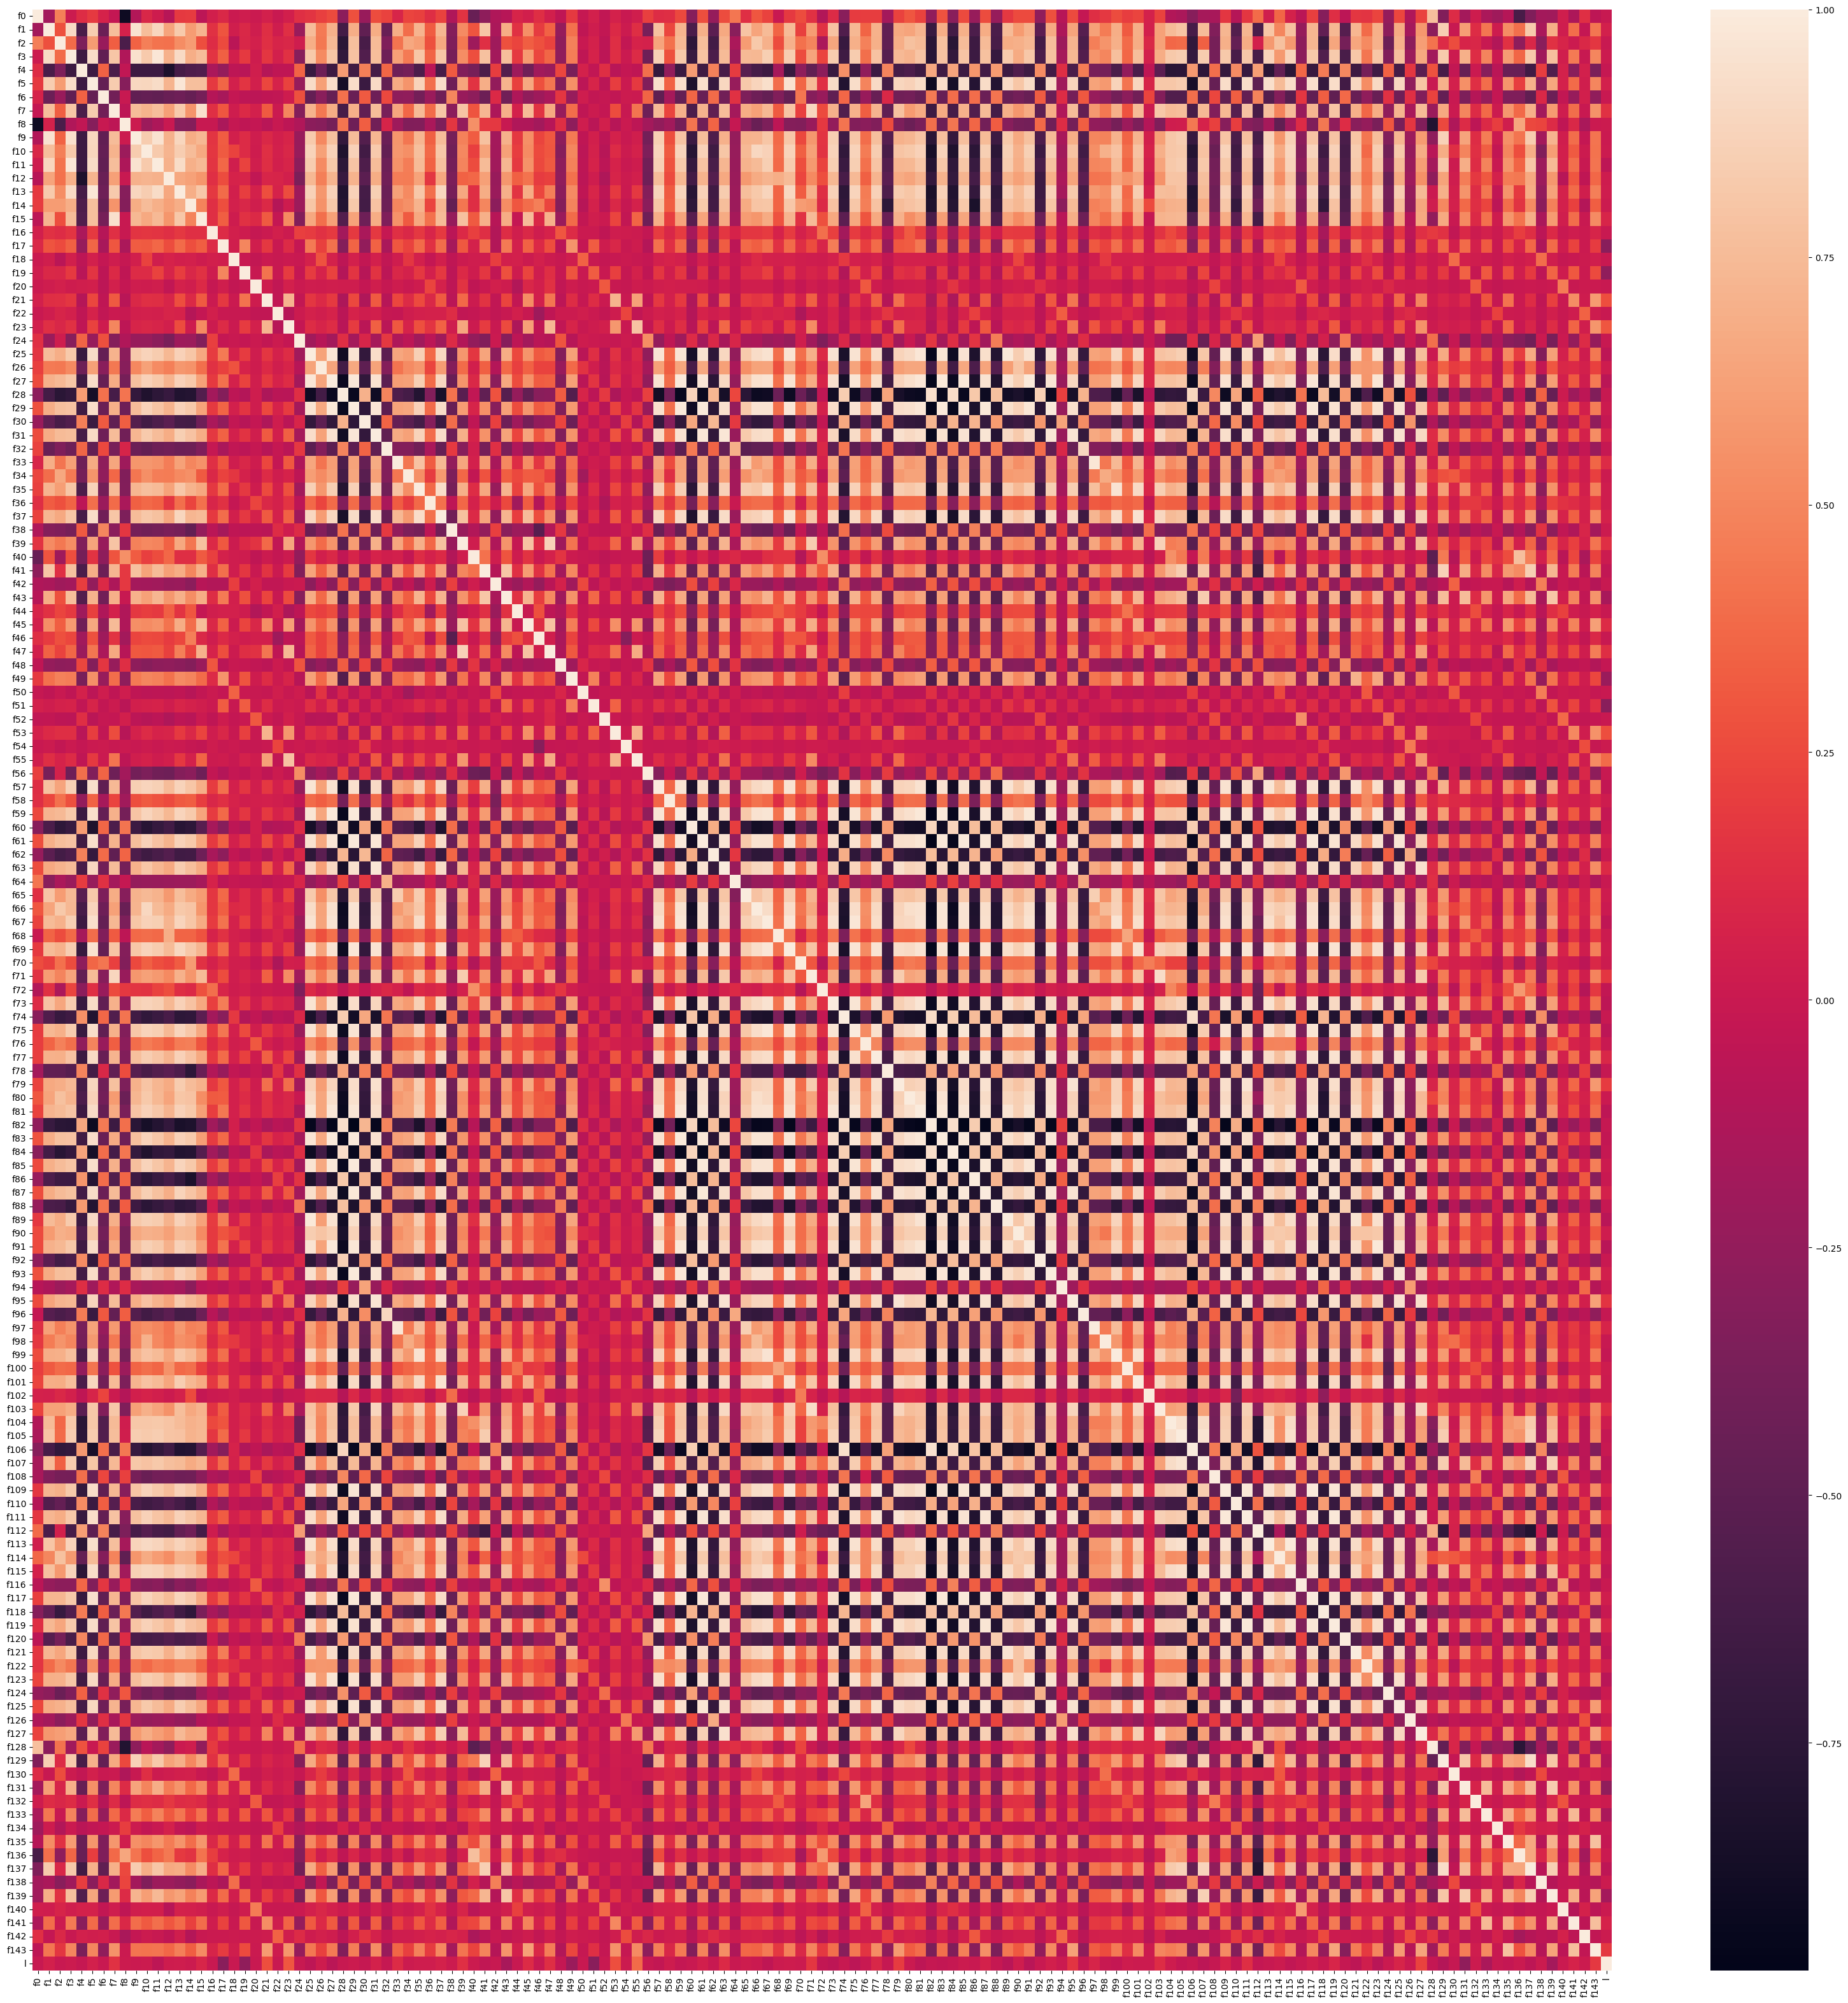

In [34]:
aaaa = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
column_names = [f'f{i}' for i in range(X_train.shape[1])] + ['l']
aaaa_df = pd.DataFrame(aaaa, columns=column_names)

corrcoef_matrix = aaaa_df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(corrcoef_matrix) # , annot=True, square=True)
plt.show()

In [40]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
corrcoefs = []
for i in range(X_train.shape[1]):
    x_ = X_train[:, i]
    y_ = y_train
    cov = ((x_ - x_.mean()) * (y_ - y_.mean())).mean()
    corrcoef = cov / (x_.std() * y_.std())
    corrcoefs.append(corrcoef)
corrcoefs = np.array(corrcoefs)

In [41]:
np.where(np.abs(corrcoefs)>0.5)

(array([], dtype=int64),)

In [37]:
np.where(np.abs(corrcoefs)<0.3)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]),)

#### distribution

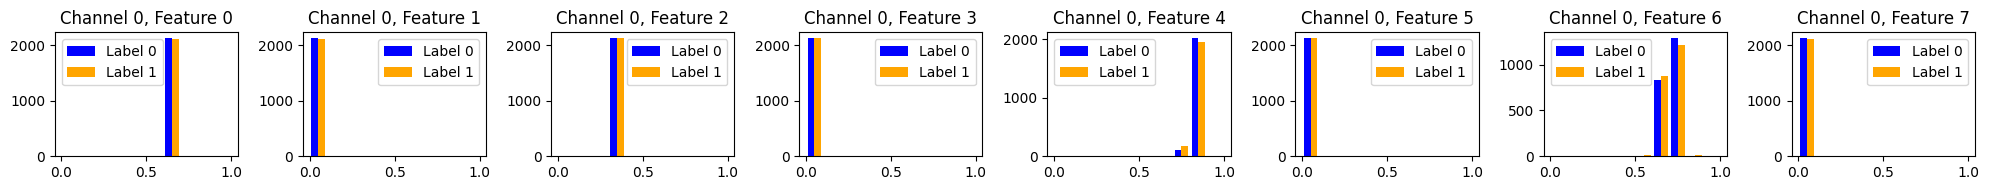

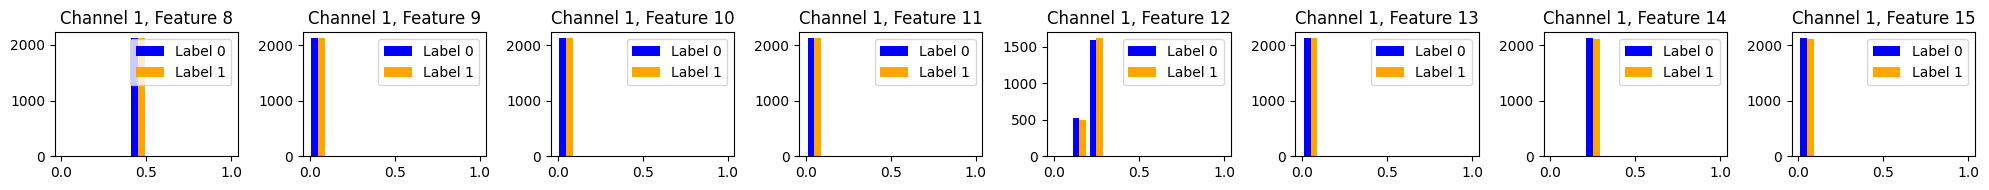

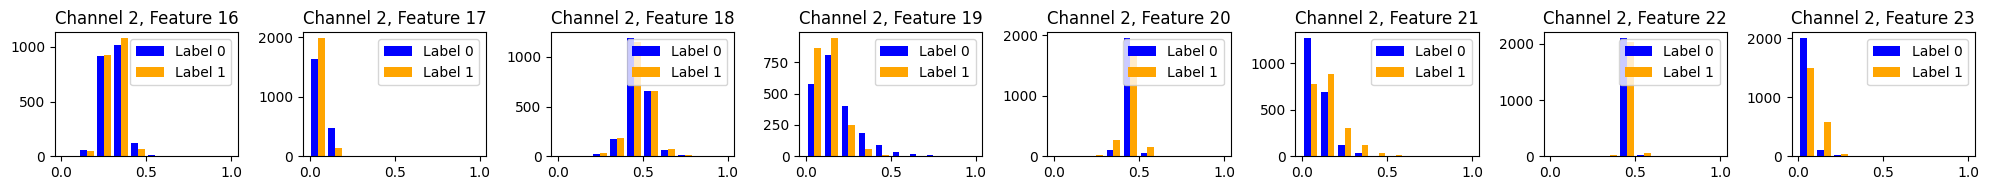

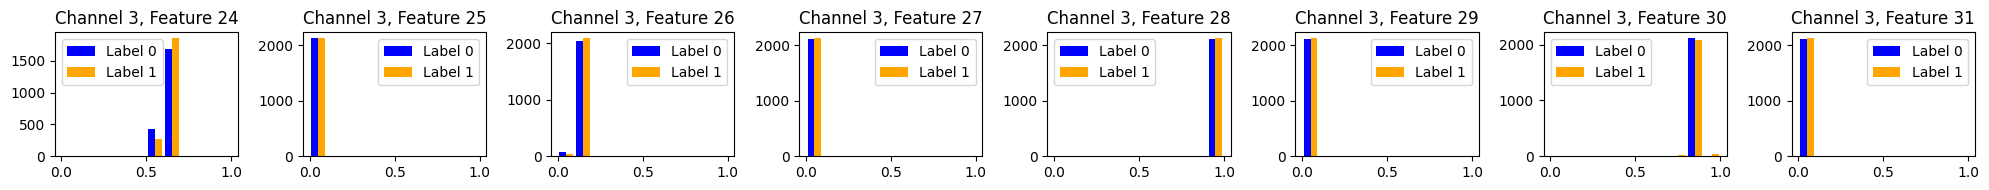

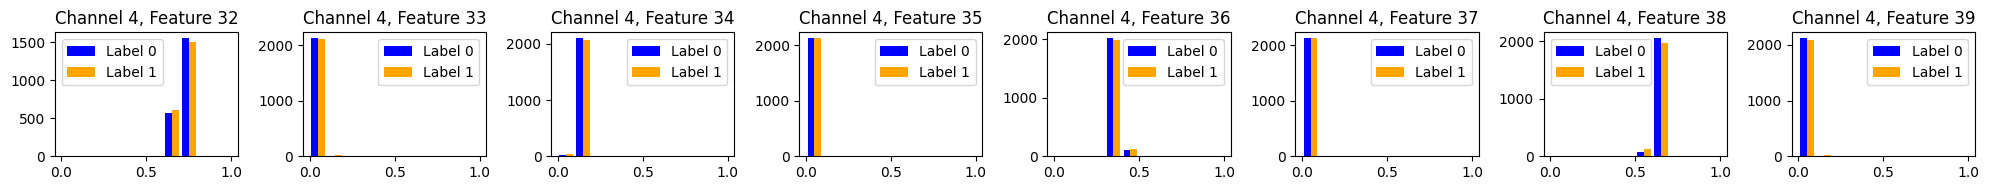

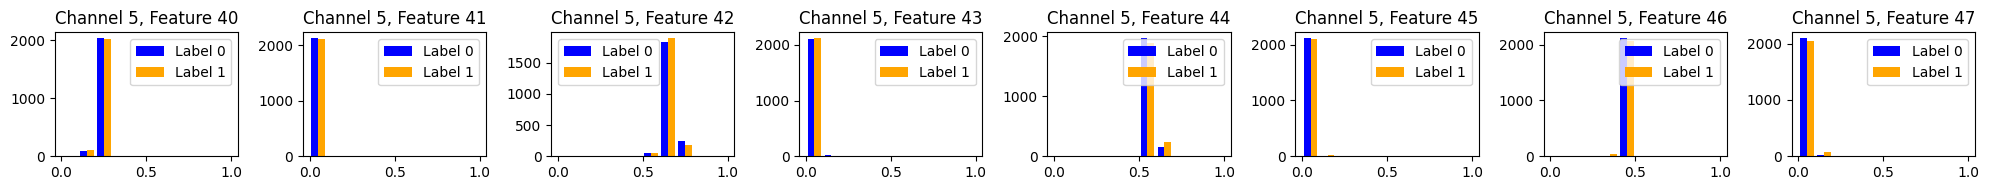

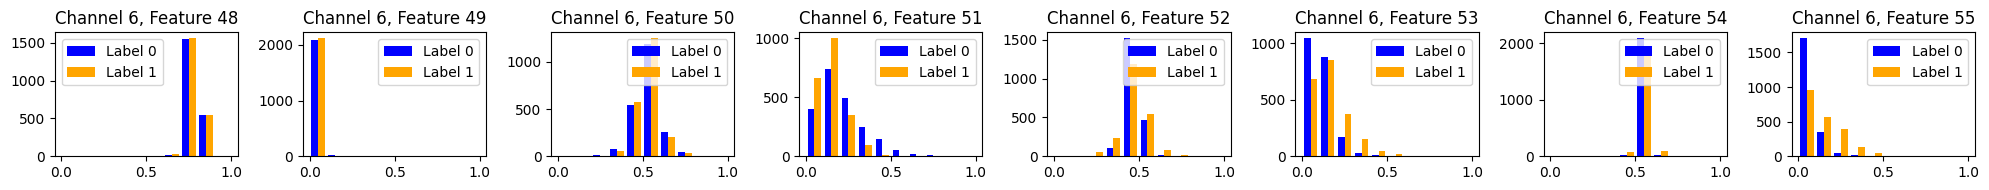

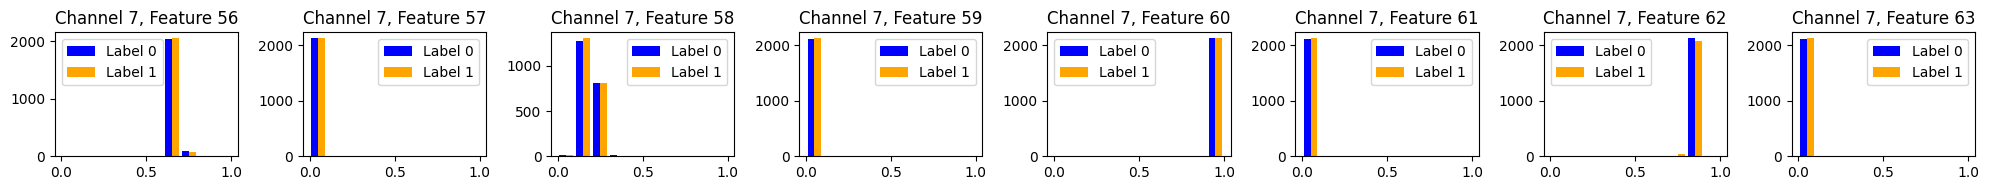

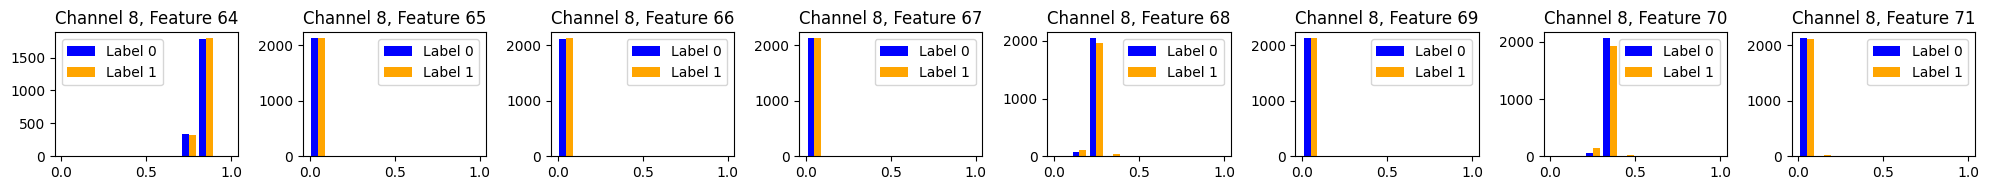

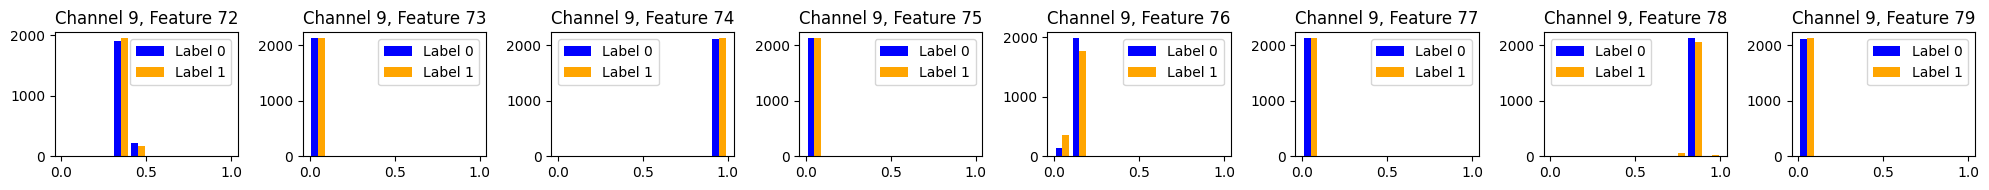

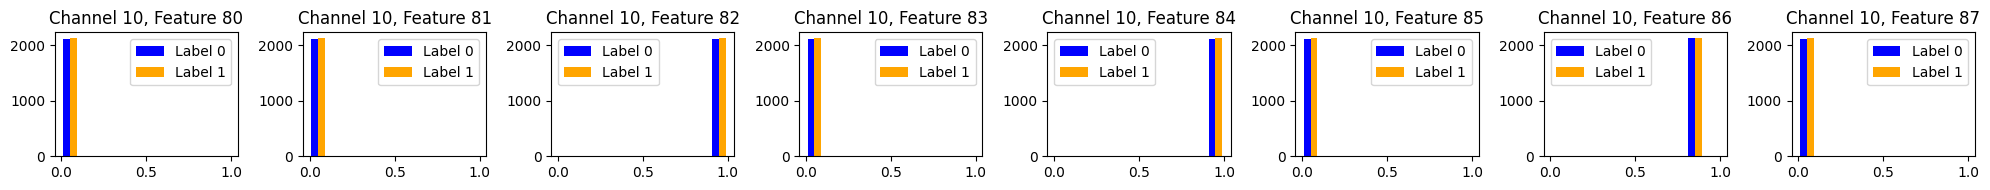

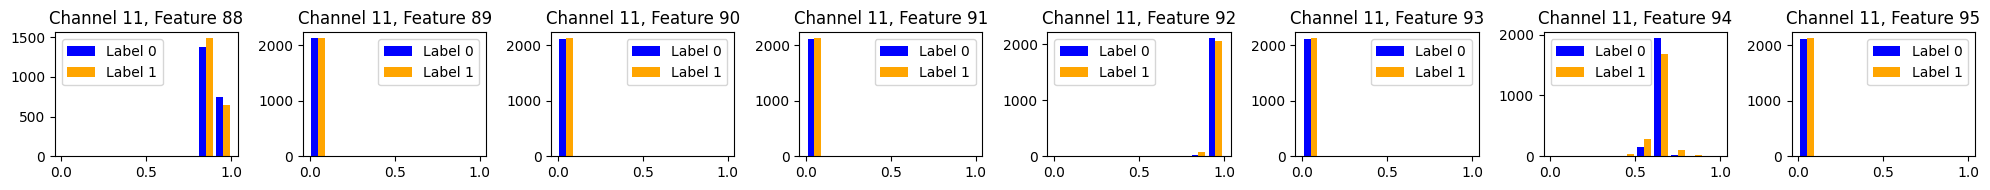

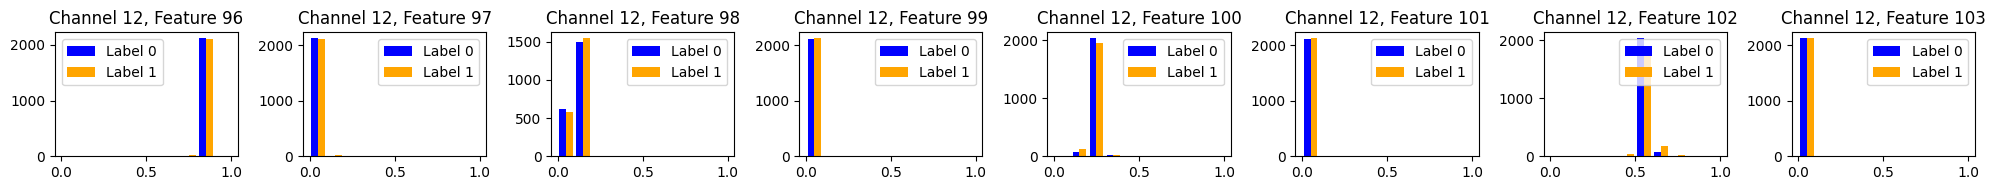

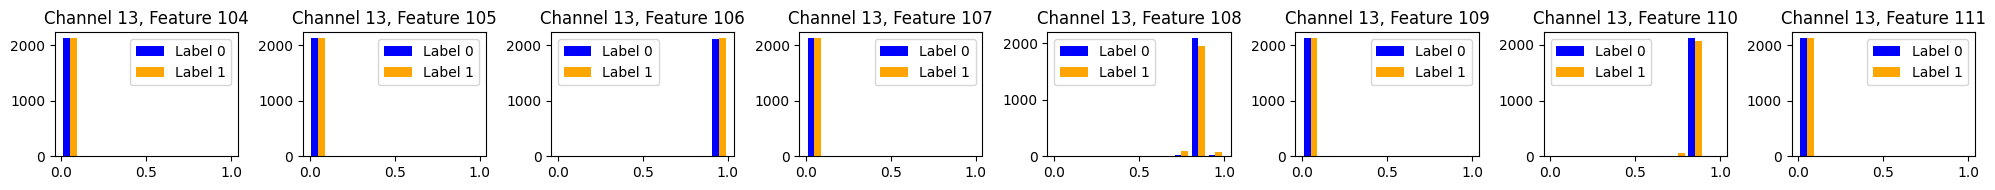

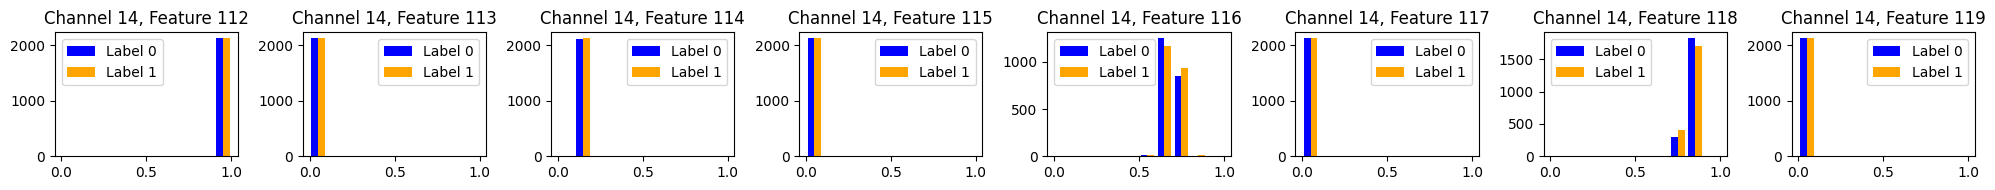

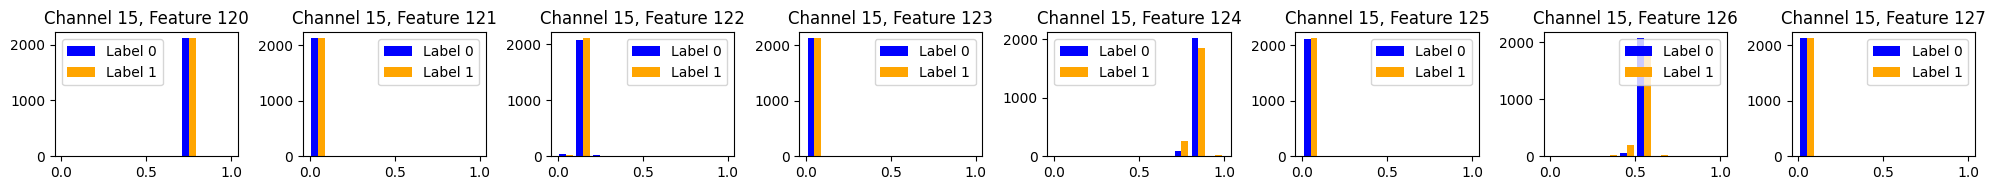

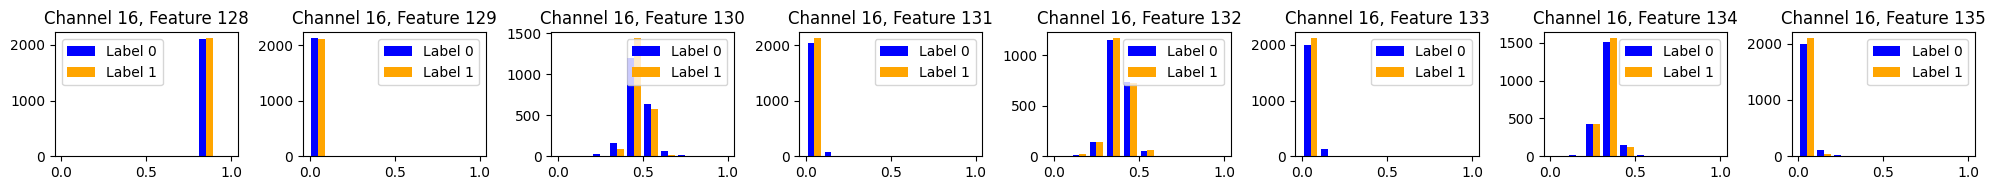

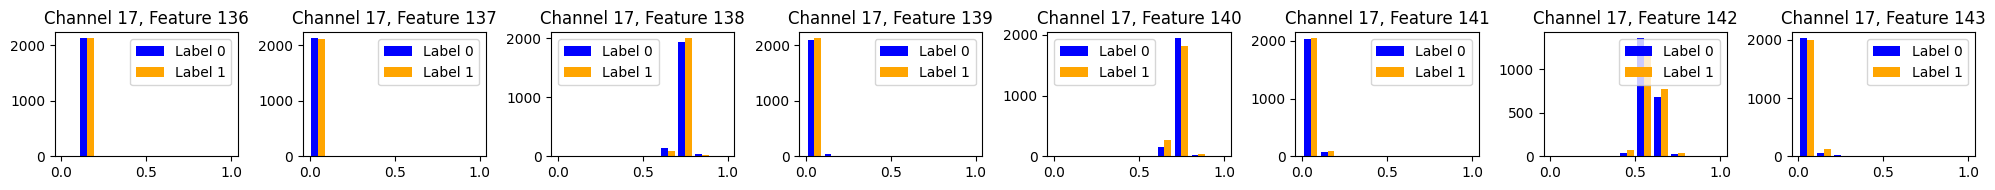

In [43]:
bbb_ = int(X_train.shape[1]/18)
for i in range(18):
    plt.figure(figsize=(20, 2))
    for j in range(bbb_):
        plt.subplot(1, bbb_, j+1)
        x_0 = X_train[:, i*bbb_+j][y_train == 0]
        x_1 = X_train[:, i*bbb_+j][y_train == 1]
        plt.hist([x_0, x_1], bins=10, color=['blue', 'orange'], label=['Label 0', 'Label 1'])
        plt.legend()
        # plt.xlabel('Feature Value')
        # plt.ylabel('Number of Samples')
        plt.title('Channel {}, Feature {}'.format(i, i*bbb_+j))
    plt.tight_layout()
    plt.show()

## 6. PCA

In [ ]:
# model
pca = PCA(n_components=10)

X_pca = pca.fit_transform(X)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)
X_test_pca = pca.fit_transform(X_test)
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

#### visualize PC distribution

In [ ]:
colors = ['red', 'blue']
for i in range(len(X_train_pca)):
    plt.scatter(X_train_pca[i, 0], X_train_pca[i, 1], color=colors[y[i]], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Components')
plt.show()

## 7. just find good models (via training set & validation set)

#### various classifiers
```
slow training: GBDT (GradientBoostingClassifier)
good scoor: SVC, LinearSVC, RandomForest, ExtraTreesClassifier, GBDT, XGBoost, KNN
```

In [ ]:
models = [LogisticRegression(), SVC(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(),
          ExtraTreesClassifier(), GradientBoostingClassifier(), XGBClassifier(), KNeighborsClassifier(), GaussianNB()
]

names = ['LogisticRegression', 'SVC', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier',
          'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'GaussianNB'
]

#### cross validation (or stratified K-folds) & various metrics 
<img src = './cross_validation.png' alt='drawing' height='350'/>

In [ ]:
def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=skf) # cv=num_folds for cross-validation, or cv=skf for stratified K-folds cross-validation
    return acc
def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=skf)
    return balanced_acc
def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision', cv=skf)
    return precision
def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall', cv=skf)
    return recall
def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1', cv=skf)
    return f1_score
def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=skf)
    return auc

#### can select with PCA or without PCA

In [ ]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    # acc
    score = acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||acc||', score.mean(), score.std()))
    # balanced acc
    score = balanced_acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||balanced_acc||', score.mean(), score.std()))
    # precision
    score = precision_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||precision||', score.mean(), score.std()))
    # recall
    score = recall_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||recall||', score.mean(), score.std()))
    # f1-score
    score = f1_score_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||f1||', score.mean(), score.std()))
    # auc
    score = auc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||auc||', score.mean(), score.std()))
    print()

## 8. hyperparameter tuning for getting best model (via training set & validation set)

#### grid search (or randomized search) & cross validation (or stratified K-folds)

In [ ]:
class GridSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid, metric):
        grid_search_CV = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=skf, scoring=metric)
        grid_search_CV.fit(X, y)
        
        best_params = grid_search_CV.best_params_
        best_score = grid_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
        
        return best_params, grid_search_CV


class RandomizedSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, random_grid, metric):
        randomized_search_CV = RandomizedSearchCV(
            estimator=model, 
            param_distributions = random_grid, 
            n_iter=100, 
            cv=skf, 
            scoring=metric,
            verbose=2, 
            random_state=4321, 
            n_jobs=-1
        )       
        randomized_search_CV.fit(X, y)

        best_params = randomized_search_CV.best_params_
        best_score = randomized_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
    
        return best_params, randomized_search_CV

#### SVC (grid search)

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.001, 0.0001]
}

model = SVC(random_state=4321, probability=True)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_svc = gs_cv.best_estimator_

#### SVC (randomized search)

In [ ]:
# random_grid = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'C': uniform(loc=0.1, scale=10),
#     'gamma': [0.1, 0.001, 0.0001] # 'gamma': ['scale', 'auto']
# }

# model = SVC(random_state=4321)
# best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hyper_search_metric)
# best_model_svc = gs_cv.best_estimator_

#### LinearSVC (grid search)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'dual': [True, False], # set dual=False when n_samples > n_features
}

model = LinearSVC(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_linearsvc = gs_cv.best_estimator_

#### RandomForest (randomized search)

In [ ]:
random_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=4321)
best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hyper_search_metric)
best_model_randomforest = gs_cv.best_estimator_

#### ExtraTreesClassifier (grid search)

In [ ]:
param_grid = {
    'n_estimators': [320, 340, 360, 380, 400],
    'max_depth': [25, 30, 32, 34, 38, 45]
}

model = ExtraTreesClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_extratrees = gs_cv.best_estimator_

#### GBDT (grid search)

In [ ]:
param_grid = {
    #'nthread':[3,4], # when use hyperthread, xgboost may become slower
    'criterion': ['friedman_mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'max_features': ['log2', 'sqrt'],
    'learning_rate': [0.01, 0.05, 0.1, 1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [5, 10, 15, 20], # number of trees, change it to 1000 for better results
}

model = GradientBoostingClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_gbdt = gs_cv.best_estimator_

#### XGBoost (grid search)

In [ ]:
param_grid = {
    'nthread':[2, 3],
    'eta': [0.01, 0.1, 1.0],
    'gamma':[0, 0.1], 
    'n_estimators':[10, 100],
    'max_depth':[2, 4], 
    'min_child_weigh':[1, 2]
}

model = XGBClassifier(random_state=4321, verbosity=0, probability=True) 
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_xgboost = gs_cv.best_estimator_

#### KNN (grid search)

In [ ]:
param_grid = {
    'n_neighbors':list(range(1, 31))
}

model = KNeighborsClassifier()
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_knn = gs_cv.best_estimator_

In [ ]:
# # logistic regression
# {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}

# # decision tree
# "criterion":("gini", "entropy"), "splitter":("best", "random"), "max_depth":(list(range(1, 20))), "min_samples_split":[2, 3, 4], "min_samples_leaf":list(range(1, 20)), 

# # naive bayes
# {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]}

## 9. save best model & best hyperparameters for test (via test set)
```
save & load trained model:
    - joblib.dump, joblib.load
    - pickle.dump, pickle.load

save & load hyperparameters:
    - clf.best_params_
```

#### save

In [ ]:
# pickle.dump(best_model, open('./DataSection-EEG/best_model.pkl', 'wb'))
# joblib.dump(best_model, './DataSection-EEG/best_model.joblib')

#### load

In [ ]:
# best_model = pickle.load(open('./DataSection-EEG/best_model.pkl', 'rb'))
# best_model = joblib.load('./DataSection-EEG/best_model.joblib')

#### just for quick check

                precision    recall  f1-score   support

    0: seizure       0.54      0.80      0.64       690
1: non-seizure       0.61      0.31      0.41       690

      accuracy                           0.55      1380
     macro avg       0.57      0.55      0.53      1380
  weighted avg       0.57      0.55      0.53      1380



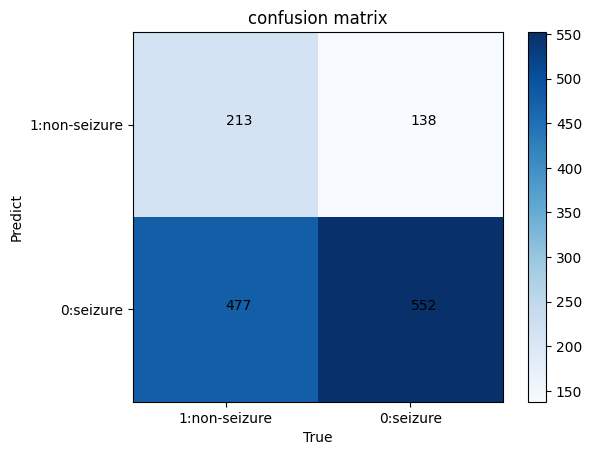

In [27]:
# clf = SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
clf = XGBClassifier(verbosity=0, probability=True)
clf.fit(X, y)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_test, y_pred)

#### 3 Metrics of Epileptic Seizure Detection: Accuracy, Sensitivity (Recall), Specificity

In [ ]:
y_test_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_test_pred))
print('Sensitivity/Recall:', recall_score(y_test, y_test_pred, pos_label=0)) # 敏感性, 默认计算正例标签1的召回率
print('Specificity:', recall_score(y_test, y_test_pred, pos_label=1)) # 特异性

#### test

In [ ]:
best_model_list = [best_model_svc, best_model_linearsvc, best_model_randomforest, best_model_extratrees, best_model_gbdt, best_model_xgboost, best_model_knn]

In [ ]:
def report_and_confusion_matrix(best_model_list, X_train, y_train, X_val, y_val, X_test, y_test):
    for best_model in best_model_list:
        print('==================== {} ===================='.format(best_model.__class__.__name__))
        # train
        y_train_pred = best_model.predict(X_train)
        print('========== train ==========')
        print(classification_report(y_train, y_train_pred, target_names=labels))
        confusion_matrix(y_train, y_train_pred)
        # val
        y_val_pred = best_model.predict(X_val)
        print('========== val ==========')
        print(classification_report(y_val, y_val_pred, target_names=labels))
        confusion_matrix(y_val, y_val_pred)
        # test
        y_test_pred = best_model.predict(X_test)
        print('========== test ==========')
        print(classification_report(y_test, y_test_pred, target_names=labels))
        confusion_matrix(y_test, y_test_pred)

In [ ]:
report_and_confusion_matrix(best_model_list, X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
def roc_and_auc(best_model_list, X_test, y_test):
    plt.figure(figsize=(10, 10))
    for best_model in best_model_list:
        # calculate fpr & tpr
        if hasattr(best_model, 'predict_proba'):
            pred_prob = best_model.predict_proba(X_test)[:, 1] # [:, 1]: prob of label 1
        else:
            pred_prob = best_model.decision_function(X_test)
        FPR, TPR, thresholds = roc_curve(y_test, pred_prob)
        # calculate AUC
        AUC = auc(FPR, TPR)
        print('{}:{:.2f}%'.format(best_model.__class__.__name__, AUC*100))
        # plot ROC curve
        plt.plot(FPR, TPR, label='{}: AUC on test = {:.2f}%'.format(best_model.__class__.__name__, AUC*100)) # lw=1, 'r'
    # plot random line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

    plt.title('ROC Curve & AUC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.xlabel('FPR (1-Specificity)')
    plt.ylabel('TPR (Recall / Sensitivity)')
    plt.show()

In [ ]:
roc_and_auc(best_model_list, X_test, y_test)